In [1]:
import numpy as np
import pdb
import matplotlib.pyplot as plt
%matplotlib inline
# plt.switch_backend('agg')
import itertools

In [2]:
def confusion_matrix(y_pred, y_real, normalize=None):
    """Compute confusion matrix.

    Args:
        y_pred (list[int] | np.ndarray[int]): Prediction labels.
        y_real (list[int] | np.ndarray[int]): Ground truth labels.
        normalize (str | None): Normalizes confusion matrix over the true
            (rows), predicted (columns) conditions or all the population.
            If None, confusion matrix will not be normalized. Options are
            "true", "pred", "all", None. Default: None.

    Returns:
        np.ndarray: Confusion matrix.
    """
    if normalize not in ['true', 'pred', 'all', None]:
        raise ValueError("normalize must be one of {'true', 'pred', "
                         "'all', None}")

    if isinstance(y_pred, list):
        y_pred = np.array(y_pred)
    if not isinstance(y_pred, np.ndarray):
        raise TypeError(
            f'y_pred must be list or np.ndarray, but got {type(y_pred)}')
    if not y_pred.dtype == np.int64:
        raise TypeError(
            f'y_pred dtype must be np.int64, but got {y_pred.dtype}')

    if isinstance(y_real, list):
        y_real = np.array(y_real)
    if not isinstance(y_real, np.ndarray):
        raise TypeError(
            f'y_real must be list or np.ndarray, but got {type(y_real)}')
    if not y_real.dtype == np.int64:
        raise TypeError(
            f'y_real dtype must be np.int64, but got {y_real.dtype}')

    label_set = np.unique(np.concatenate((y_pred, y_real)))
    num_labels = len(label_set)
    label_map = {label: i for i, label in enumerate(label_set)}
    confusion_mat = np.zeros((num_labels, num_labels), dtype=np.int64)
    for rlabel, plabel in zip(y_real, y_pred):
        index_real = label_map[rlabel]
        index_pred = label_map[plabel]
        confusion_mat[index_real][index_pred] += 1

    with np.errstate(all='ignore'):
        if normalize == 'true':
            confusion_mat = (
                confusion_mat / confusion_mat.sum(axis=1, keepdims=True))
        elif normalize == 'pred':
            confusion_mat = (
                confusion_mat / confusion_mat.sum(axis=0, keepdims=True))
        elif normalize == 'all':
            confusion_mat = (confusion_mat / confusion_mat.sum())
        confusion_mat = np.nan_to_num(confusion_mat)

    return confusion_mat

In [29]:
# set up path for thh reference (baseline) model prediction and its ground truth
# The reason why we have two different ground truth is that the orders could be different across different machines
ref_prediction_path = '../../work_dirs/r2plus1d_r34_video_3d_8x8x1_900e_ucf101_rgb_20percent_vidssl/results.pkl'
ref_gt_labels_path = '../../work_dirs/r2plus1d_r34_video_8x8x1_180e_ucf101_rgb_fixmatch_20percent_vidssl/gt_labels.npy'
# ref_prediction_path = '../../work_dirs/r2plus1d_r34_video_8x8x1_360e_ucf101_rgb_all_20percent_vidssl/results.pkl' # final model, CVPR
# ref_gt_labels_path = '../../work_dirs/r2plus1d_r34_video_3d_8x8x1_900e_ucf101_rgb_20percent_vidssl/gt_labels_new.npy'

# class names 
classnames_path = '../../work_dirs/r2plus1d_r34_video_8x8x1_180e_ucf101_rgb_fixmatch_20percent_vidssl/classnames.npy'

# set up the path for the compared (proposed) model predictions, and its ground truth
# comp_prediction_path = '../../work_dirs/r2plus1d_r34_video_8x8x1_180e_ucf101_rgb_taugment_20percent_vidssl/results.pkl' # temp aug all only
# comp_gt_labels_path = '../../work_dirs/r2plus1d_r34_video_8x8x1_180e_ucf101_rgb_fixmatch_20percent_vidssl/gt_labels.npy'
# comp_prediction_path = '../../work_dirs/r2plus1d_r34_video_8x8x1_180e_ucf101_rgb_actorcutmix_20percent_vidssl/results.pkl' # ActorCutMix only
# comp_gt_labels_path = '../../work_dirs/r2plus1d_r34_video_3d_8x8x1_900e_ucf101_rgb_20percent_vidssl/gt_labels_new.npy'
comp_prediction_path = '../../work_dirs/r2plus1d_r34_video_8x8x1_360e_ucf101_rgb_all_20percent_vidssl/results.pkl' # final model, CVPR
comp_gt_labels_path = '../../work_dirs/r2plus1d_r34_video_3d_8x8x1_900e_ucf101_rgb_20percent_vidssl/gt_labels_new.npy'

# comp_prediction_path = '../../work_dirs/r2plus1d_r34_video_8x8x1_45e_ucf101-kinetics100_rgb_all_full_vidssl_1GPU/results.pkl' # final model with Kinetics unlabeled
# comp_gt_labels_path = '../../work_dirs/r2plus1d_r34_video_3d_8x8x1_900e_ucf101_rgb_20percent_vidssl/gt_labels_new.npy'

# set up the output bar chart path for both worse classes and better classes
# comp_output_bar_chart_path = '../../work_dirs/compare_cls_acc_ref_temp_aug_only.pdf'
# comp_output_bar_chart_path = '../../work_dirs/compare_cls_acc_ref_acm_only.pdf'
comp_output_bar_chart_path = '../../work_dirs/compare_cls_acc_ref_ours_final.pdf'
# canvas size
figsize = (40,10)

# normalize or not
normalize = 'true'
# normalize = None

In [30]:
# read the data
ref_preds = np.load(ref_prediction_path, allow_pickle=True)
ref_preds = [entry.argmax() for entry in ref_preds]
comp_preds = np.load(comp_prediction_path, allow_pickle=True)
comp_preds = [entry.argmax() for entry in comp_preds]
ref_gt_labels = np.load(ref_gt_labels_path)
comp_gt_labels = np.array(np.load(comp_gt_labels_path, allow_pickle=True))
classnames = np.load(classnames_path)

In [31]:
# compute ref model confmat, top-1 accuracy
confmat_ref = confusion_matrix(ref_preds, ref_gt_labels, normalize=normalize)
if normalize == 'true':
    ref_overall_acc = np.sum(np.diag(confmat_ref))
    print('Ref pred top-1 accuracy: {:.2f}%'.format(ref_overall_acc))
else:
    ref_overall_acc = np.sum(np.diag(confmat_ref))/float(len(ref_gt_labels))
    print('Ref pred top-1 accuracy: {:.2f}%'.format(100*ref_overall_acc))

# compute compared model confmat, top-1 accuracy
confmat_comp = confusion_matrix(comp_preds, comp_gt_labels, normalize=normalize)
if normalize == 'true':
    comp_overall_acc = np.sum(np.diag(confmat_comp))
    print('Compared pred accuracy: {:.2f}%'.format(comp_overall_acc))
else:
    comp_overall_acc = np.sum(np.diag(confmat_comp))/float(len(comp_gt_labels))
    print('Compared pred accuracy: {:.2f}%'.format(100*comp_overall_acc))

Ref pred top-1 accuracy: 39.28%
Compared pred accuracy: 57.05%


In [32]:
cls_acc_ref = np.diag(confmat_ref)
cls_acc_ours = np.diag(confmat_comp)

In [33]:
sorted_idx = np.argsort(cls_acc_ref)
label_range = np.arange(len(classnames))

cls_acc_ref_sorted = cls_acc_ref[sorted_idx]
cls_acc_ours_sorted = cls_acc_ours[sorted_idx]
classnames_sorted = classnames[sorted_idx]

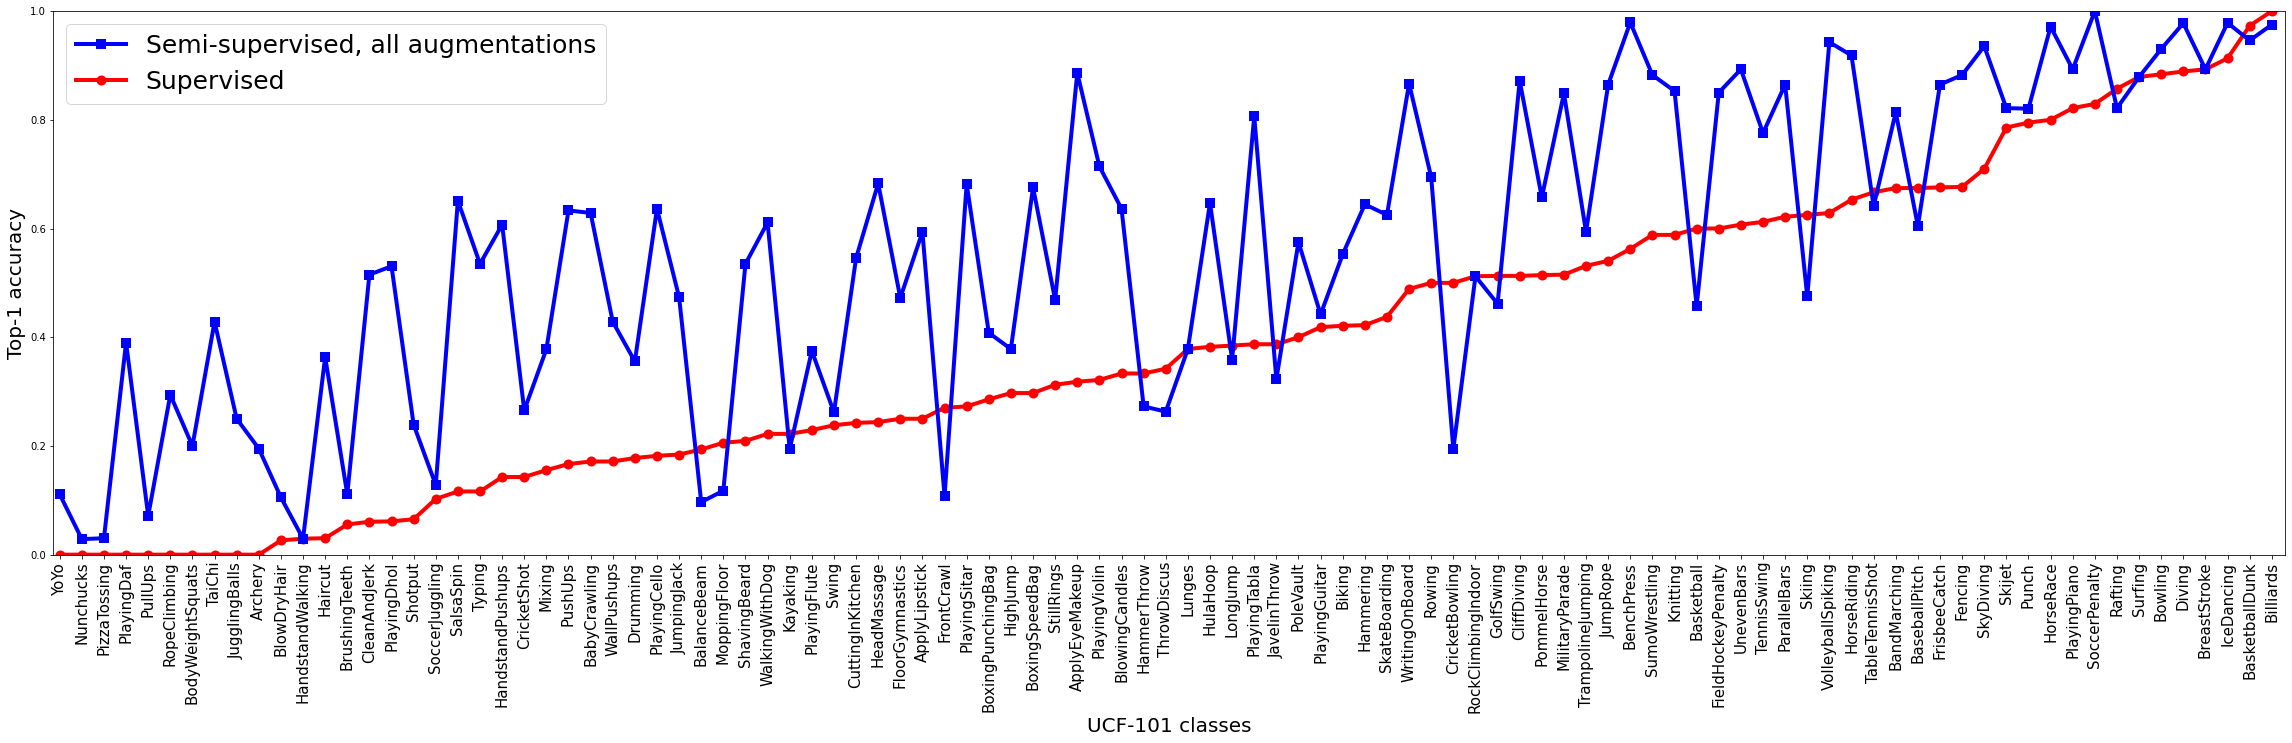

In [34]:
fig = plt.figure(figsize=figsize)

line_ref, = plt.plot(label_range, cls_acc_ref_sorted, '-o', color='red',
                    markersize=8, linewidth=4,
                    markerfacecolor='red',
                    markeredgecolor='red',
                    markeredgewidth=2)
line_ours, = plt.plot(label_range, cls_acc_ours_sorted, '-s', color='b',
                     markersize=8, linewidth=4,
                     markerfacecolor='b',
                     markeredgecolor='b',
                     markeredgewidth=2)

plt.xticks(label_range, classnames_sorted,fontsize=15,rotation=90)

plt.xlim([-0.3,len(label_range)-0.4])
plt.ylim([0,1.0])

plt.xlabel('UCF-101 classes', fontsize=20)
plt.ylabel('Top-1 accuracy', fontsize=20)

# plt.legend([line_ours,line_ref], ['Semi-supervised, temporal augmentations only','Supervised'],prop={'size': 25})
# plt.legend([line_ours,line_ref], ['Semi-supervised, ActorCutMix augmentation only','Supervised'],prop={'size': 25})
plt.legend([line_ours,line_ref], ['Semi-supervised, all augmentations','Supervised'],prop={'size': 25})
# plt.legend([line_ours,line_ref], ['With additional data','Baseline'],prop={'size': 25})


plt.show()

fig.savefig(comp_output_bar_chart_path,  bbox_inches='tight') 